#### NOTE: 

This notebook is an updated version of the notebook used in the **hands-on lecture**.

The following changes have been made:

1. random_state parameter is set in the Decision Tree model used as base_estimator while tuning the AdaBoostClassifier().

    * In the video, the random_state parameter was not set in the Decision Tree model while tuning AdaBoostClassifier, which might result in different hyperparameters being selected by the GridSearchCV(). In the updated notebook, we have set the random_state value, which will ensure that results do not change when the code cell is re-run.

# Ensemble Hands On - Boosting

We are going to build a model that predicts if someone who seeks a loan might be a defaulter or a non-defaulter. We have several independent variables like, checking account balance, credit history, purpose, loan amount etc.

## Import Libraries

In [25]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
#To install xgboost library use - !pip install xgboost 
from xgboost import XGBClassifier

**We will use the same `credit data` used in decision tree hands-on lecture.**

In [26]:
creditData = pd.read_csv("Cars-dataset.csv")

#creditData = pd.read_csv("credit.csv")
creditData.head(10) #several missing values!

,Age,Gender,Engineer,MBA,Work Exp,Salary,Distance,license,Opt_service
0,28,Male,1,0,5,14.4,5.1,0,0
1,24,Male,1,0,6,10.6,6.1,0,0
2,27,Female,1,0,9,15.5,6.1,0,0
3,25,Male,0,0,1,7.6,6.3,0,0
4,25,Female,0,0,3,9.6,6.7,0,0
5,21,Male,0,0,3,9.5,7.1,0,0
6,23,Male,1,1,3,11.7,7.2,0,0
7,23,Male,0,0,0,6.5,7.3,0,0
8,24,Male,1,0,4,8.5,7.5,0,0
9,28,Male,1,0,6,13.7,7.5,1,0


In [27]:
creditData.shape

(418, 9)

In [28]:
creditData['Opt_service'].value_counts()

0    383
1     35
Name: Opt_service, dtype: int64

In [29]:
creditData.describe()

,Age,Engineer,MBA,Work Exp,Salary,Distance,license,Opt_service
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,27.334928,0.748804,0.260766,5.873206,15.418421,11.306220,0.205742,0.083732
std,4.153272,0.434221,0.439578,4.816110,9.660234,3.722143,0.404727,0.277317
min,18.000000,0.000000,0.000000,0.000000,6.500000,3.200000,0.000000,0.000000
25%,25.000000,0.250000,0.000000,3.000000,9.625000,8.600000,0.000000,0.000000
50%,27.000000,1.000000,0.000000,5.000000,13.000000,10.900000,0.000000,0.000000
75%,29.000000,1.000000,1.000000,8.000000,14.900000,13.575000,0.000000,0.000000
max,43.000000,1.000000,1.000000,24.000000,57.000000,23.400000,1.000000,1.000000


In [30]:
creditData.info()  # many columns are of type object i.e. strings. These need to be converted to ordinal type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          418 non-null    int64  
 1   Gender       418 non-null    object 
 2   Engineer     418 non-null    int64  
 3   MBA          418 non-null    int64  
 4   Work Exp     418 non-null    int64  
 5   Salary       418 non-null    float64
 6   Distance     418 non-null    float64
 7   license      418 non-null    int64  
 8   Opt_service  418 non-null    int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 29.5+ KB


Lets convert the columns with an 'object' datatype into categorical variables

In [31]:
creditData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          418 non-null    int64  
 1   Gender       418 non-null    object 
 2   Engineer     418 non-null    int64  
 3   MBA          418 non-null    int64  
 4   Work Exp     418 non-null    int64  
 5   Salary       418 non-null    float64
 6   Distance     418 non-null    float64
 7   license      418 non-null    int64  
 8   Opt_service  418 non-null    int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 29.5+ KB


## Split the data into train and test sets

- When data (classification) exhibit a significant imbalance in the distribution of the target classes, it is good to use stratified sampling to ensure that relative class frequencies are approximately preserved in train and test sets. 
- This is done by setting the `stratify` parameter to target variable in the train_test_split function.

In [32]:
X = creditData.drop("Opt_service" , axis=1)
y = creditData.pop("Opt_service")

In [33]:
X= pd.get_dummies(X, columns = ['Gender'],drop_first = True)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=1,stratify=y)

**We will use the same functions, created in bagging hands-on lecture, to calculate different metrics and plot the confusion matrix.**

In [35]:
## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))
    
    return score_list # returning the list with train and test scores

## Building the model
- We are going to build 3 ensemble models here - AdaBoost Classifier, Gradient Boosting Classifier and XGBoost Classifier.
- First, let's build these models with default parameters and then use hyperparameter tuning to optimize the model performance.
- We will calculate all three metrics - Accuracy, Precision and Recall but the metric of interest here is recall.
- `Recall` - It gives the ratio of True positives to Actual positives, so high Recall implies low false negatives, i.e. low chances of predicting a defaulter as non defaulter

### AdaBoost Classifier

In [37]:
abc = AdaBoostClassifier(random_state=1)
abc.fit(X_test,y_test)

AdaBoostClassifier(random_state=1)

In [38]:
#Using above defined function to get accuracy, recall and precision on train and test set
abc_score=get_metrics_score(abc)

Accuracy on training set :  0.976027397260274
Accuracy on test set :  1.0
Recall on training set :  1.0
Recall on test set :  1.0
Precision on training set :  0.7741935483870968
Precision on test set :  1.0


### Gradient Boosting Classifier

In [39]:
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(random_state=1)

In [40]:
#Using above defined function to get accuracy, recall and precision on train and test set
gbc_score=get_metrics_score(gbc)

Accuracy on training set :  1.0
Accuracy on test set :  0.9603174603174603
Recall on training set :  1.0
Recall on test set :  0.9090909090909091
Precision on training set :  1.0
Precision on test set :  0.7142857142857143


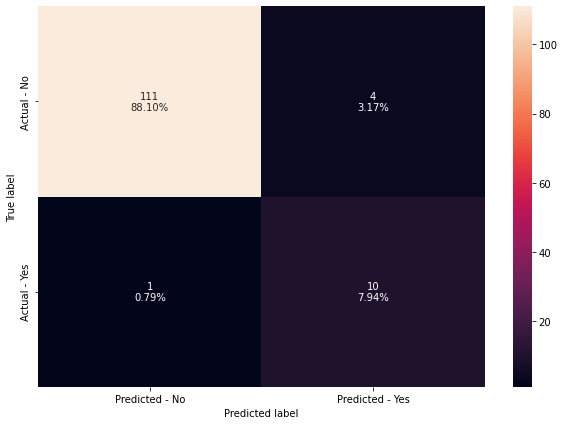

In [41]:
make_confusion_matrix(gbc,y_test)

### XGBoost Classifier

In [42]:
raise ValueError('A very specific bad thing happened.')


ValueError: A very specific bad thing happened.

In [ ]:
xgb = XGBClassifier(random_state=1,eval_metric='logloss')
xgb.fit(X_train,y_train)

In [ ]:
#Using above defined function to get accuracy, recall and precision on train and test set
xgb_score=get_metrics_score(xgb)

In [ ]:
make_confusion_matrix(xgb,y_test)

**With default parameters:**
- AdaBoost classifier has better test accuracy among these 3 models.
- GB classifier has least test accuracy and test recall.

## Hyperparameter Tuning

### AdaBoost Classifier

- An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.
- Some important hyperparamters are:
    - base_estimator: The base estimator from which the boosted ensemble is built. By default the base estimator is a decision tree with max_depth=1
    - n_estimators: The maximum number of estimators at which boosting is terminated. Default value is 50.
    - learning_rate: Learning rate shrinks the contribution of each classifier by learning_rate. There is a trade-off between learning_rate and n_estimators.

In [ ]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1, random_state=1),DecisionTreeClassifier(max_depth=2, random_state=1),DecisionTreeClassifier(max_depth=3, random_state=1)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

In [ ]:
#Using above defined function to get accuracy, recall and precision on train and test set
abc_tuned_score=get_metrics_score(abc_tuned)

In [ ]:
make_confusion_matrix(abc_tuned,y_test)

### Insights
- The model is overfitting the train data as train accuracy is much higher than the test accuracy.
- The model has low test recall. This implies that the model is not good at identifying defaulters.

In [ ]:
importances = abc_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- Amount is the most important feature as per the tuned AdaBoost model.

### Gradient Boosting Classifier

- Most of the hyperparameters available are same as random forest classifier.
- init: An estimator object that is used to compute the initial predictions. If ‘zero’, the initial raw predictions are set to zero. By default, a DummyEstimator predicting the classes priors is used.
- There is no class_weights parameter in gradient boosting.

**Let's try using AdaBoost classifier as the estimator for initial predictions**

In [ ]:
gbc_init = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)
gbc_init.fit(X_train,y_train)

In [ ]:
#Using above defined function to get accuracy, recall and precision on train and test set
gbc_init_score=get_metrics_score(gbc_init)

**As compared to the model with default parameters:**

- Test accuracy and test recall have increased slightly.
- As we are getting better results, we will use init = AdaBoostClassifier() to tune the gradient boosting model.

In [ ]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

In [ ]:
#Using above defined function to get accuracy, recall and precision on train and test set
gbc_tuned_score=get_metrics_score(gbc_tuned)

In [ ]:
make_confusion_matrix(gbc_tuned,y_test)

### Insights
- The model performace has not increased by much.
- The model has started to overfit the train data in terms of recall.
- It is better at identifying non-defaulters than identifying defaulters which is the opposite of the result we need.

In [ ]:
importances = gbc_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- Amount is the most important feature, followed by loan duration and checking balance, as per the tuned gradient boosting model

### XGBoost Classifier

**XGBoost has many hyper parameters which can be tuned to increase the model performance. You can read about them in the xgboost documentation [here](https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters). Some of the important parameters are:**
- scale_pos_weight:Control the balance of positive and negative weights, useful for unbalanced classes. It has range from 0 to $\infty$.
- subsample: Corresponds to the fraction of observations (the rows) to subsample at each step. By default it is set to 1 meaning that we use all rows.
- colsample_bytree: Corresponds to the fraction of features (the columns) to use.
- colsample_bylevel: The subsample ratio of columns for each level. Columns are subsampled from the set of columns chosen for the current tree.
- colsample_bynode: The subsample ratio of columns for each node (split). Columns are subsampled from the set of columns chosen for the current level.
- max_depth: is the maximum number of nodes allowed from the root to the farthest leaf of a tree.
- learning_rate/eta: Makes the model more robust by shrinking the weights on each step.
- gamma: A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.

In [ ]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1,eval_metric='logloss')

# Grid of parameters to choose from
## add from
parameters = {
    "n_estimators": np.arange(10,100,20),
    "scale_pos_weight":[0,1,2,5],
    "subsample":[0.5,0.7,0.9,1],
    "learning_rate":[0.01,0.1,0.2,0.05],
    "gamma":[0,1,3],
    "colsample_bytree":[0.5,0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

In [ ]:
#Using above defined function to get accuracy, recall and precision on train and test set
xgb_tuned_score=get_metrics_score(xgb_tuned)

In [ ]:
make_confusion_matrix(xgb_tuned,y_test)

### Insights
- The test accuracy of the model has reduced as compared to the model with default parameters but the recall has increased significantly and the model is able to identify most of the defaulters.
- Decreasing number of false negatives has increased the number of false positives here.
- The tuned model is not overfitting and generalizes well.

In [ ]:
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- Checking balance is the most important feature as per XGBoost model unlike AdaBoost and Gradient Boosting, where the most important feature is the amount.

## Comparing all models

In [ ]:
# defining list of models
models = [abc, abc_tuned, gbc, gbc_init, gbc_tuned, xgb, xgb_tuned]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the accuracy, precall and precision scores
for model in models:
    j = get_metrics_score(model,False)
    acc_train.append(np.round(j[0],2))
    acc_test.append(np.round(j[1],2))
    recall_train.append(np.round(j[2],2))
    recall_test.append(np.round(j[3],2))
    precision_train.append(np.round(j[4],2))
    precision_test.append(np.round(j[5],2))

In [ ]:
comparison_frame = pd.DataFrame({'Model':['AdaBoost with default paramters','AdaBoost Tuned', 
                                          'Gradient Boosting with default parameters','Gradient Boosting with init=AdaBoost',
                                          'Gradient Boosting Tuned','XGBoost with default parameters','XGBoost Tuned'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test}) 
comparison_frame

### Remark:
- A `Cost Function` quantifies the error between predicted values and expected values and presents it in the form of a single real number.
- The bank can choose a model depending on their cost function which they want to minimize. The cost function can depend on the geographical and economical conditions due to changes in interest rates, government rules etc.
- Bank's main aim would be to balance the trade off between losing an opportunity (to gain money by giving loans) in case of FP and losing the money in case of FN.
- We emphasized that recall is the metric of interest here and we tuned our model on recall. But this does not mean that other metrics should be ignored completely.
- Here, we assumed that the $cost\ on\ FN>cost\ on\ FP$, but we do not want to misclassify so many non-defaulters that the equation is reversed i.e. $cost\ on\ FP>cost\ on\ FN$, hence, the bank will actually be losing money in the longer run.
- `For example:` Let's say a bank gains 4% interest on the amount while giving loans to non-defaulters and lose 70% on the amount while giving loans to defaulters and also assume that the amount of loan is also fixed. Let's say we use a model which is only good at identifying defaulters and we get the following result:
    - The model identifies 10 out of 10 defaulters
    - The model identifies 10 out of 190 non-defaulters i.e. misclassified 180 non-defaulters
    - Then, the money saved is $0.7*10*amount=7*amount$ and the money lost is $0.04*180*amount=7.2*amount$
    - As the value of money lost is greater than the value of money saved, bank will actually lose money even after identifying all defaulters